<a href="https://colab.research.google.com/github/asifahmed90/Time-Series-Analysis/blob/master/Cryptocurrency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing Bidirectional LSTM and GRU model for Time Series Analysis


Load the necessary Library in your notebook.

In [1]:
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM,GRU
 
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
 
from sklearn.preprocessing import MinMaxScaler
 
from datetime import date
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##Dataset Description

We need to upload data before proceeding with the analysis. I used cryptocurrency data from Kaggle. The data can be found here in this [link](https://www.kaggle.com/mczielinski/bitcoin-historical-data).

The dataset presents minute by minute bitcoin prices along with some other factors for the past couple of years. However, there are two datasets, for training and testing. For this initial analysis and tutorial, we will only deal with one dataset to keep it simple. 


After uploading the dataset, we need to convert the "Timestamp" column into "Date" format. Timestamp are machine generated log file format and can be confusing for us while analyzing the dataset. Instead we can look into the data by considering dates instead of timestamp.
We can use pandas to_datetime to convert the timestamp into date format.

In [2]:
dataset = pd.read_csv('btcusd_1-min_data.csv')


dataset['Date'] = pd.to_datetime(dataset['Timestamp'], unit='s').dt.date
 
group = dataset.groupby('Date') 
dataset




,Timestamp,Open,High,Low,Close,Volume,Date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
...,...,...,...,...,...,...,...
6716276,1.732061e+09,92330.00,92412.00,92330.00,92404.00,3.370799,2024-11-19
6716277,1.732061e+09,92405.00,92405.00,92342.00,92343.00,0.081985,2024-11-19
6716278,1.732061e+09,92343.00,92424.00,92343.00,92424.00,1.247212,2024-11-19
6716279,1.732061e+09,92434.00,92479.00,92395.00,92461.00,2.841287,2024-11-20


In [3]:
#Data cleaning
dataset.isna().sum()

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
Date         1
dtype: int64

In [4]:
# Drop rows where 'Timestamp' or 'Date' are missing
dataset = dataset.dropna(subset=['Timestamp', 'Date'])

# After dropping, check if any missing values remain
print(dataset.isna().sum())

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
Date         0
dtype: int64


Since we will analyze the data based on time i.e. months and year, we need to set new converted 'Date' column as our primary index. 

In [5]:
#setting index as date

dataset.index = dataset['Date']

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716280 entries, 2012-01-01 to 2024-11-20
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   Date       object 
dtypes: float64(6), object(1)
memory usage: 409.9+ MB


Here is the fun part. Lets plot some figure and try to see more closely to our dataset based on dates.

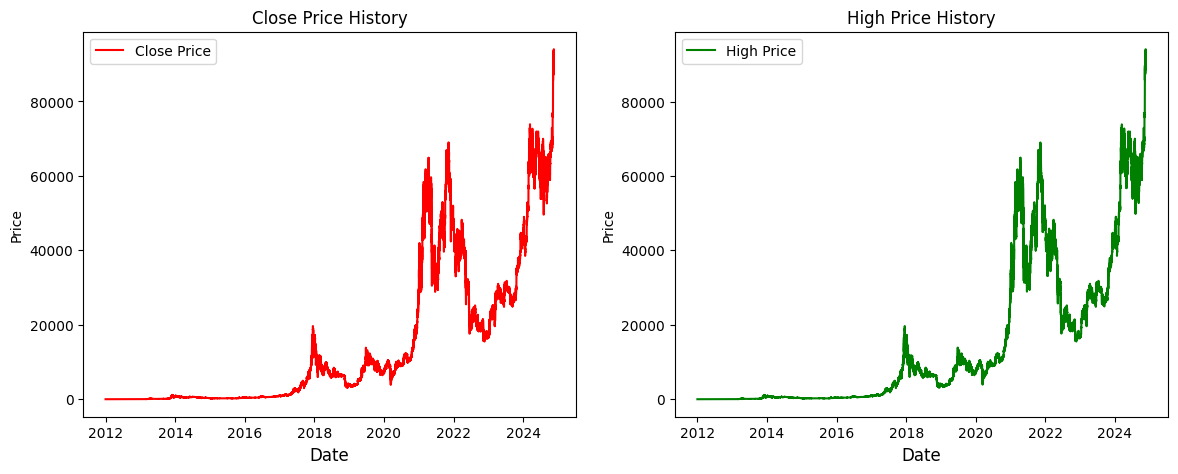

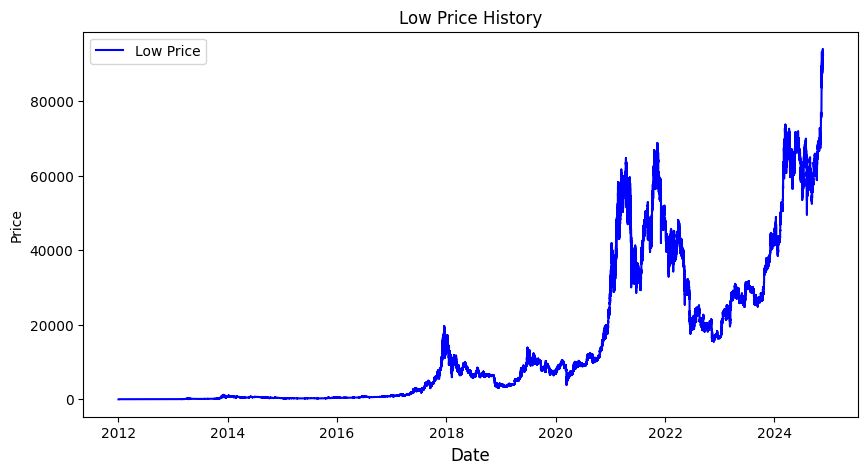

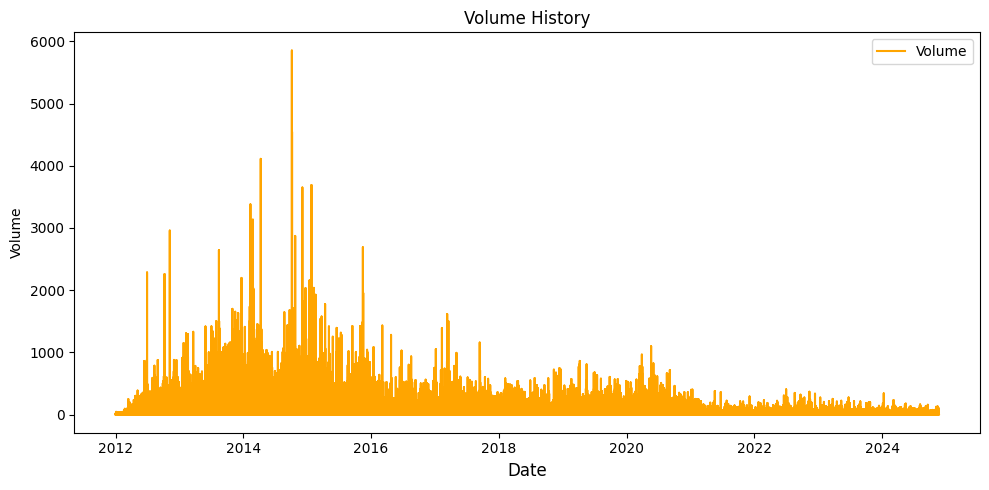

In [6]:
# Simple plotting of Cryptocurrency Price
# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# First Subplot: Close Price History
ax1.plot(dataset.index, dataset["Close"], label="Close Price", color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price")
ax1.set_title("Close Price History")
ax1.legend()

# Second Subplot: High Price History
ax2.plot(dataset.index, dataset["High"], label="High Price", color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Price")
ax2.set_title("High Price History")
ax2.legend()

# Third Subplot: Low Price History
f, (ax3) = plt.subplots(figsize=(10,5))
ax3.plot(dataset.index, dataset["Low"], label="Low Price", color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Price")
ax3.set_title("Low Price History")
ax3.legend()

# Fourth Subplot: Volume History
f, (ax4) = plt.subplots(figsize=(10,5))
ax4.plot(dataset.index, dataset["Volume"], label="Volume", color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("Volume History")
ax4.legend()

plt.tight_layout()
plt.show()


Now that we have done some initial analysis, we can try to format our data so that it would be easier for us to analyze. We can use MinMaxScaler() to normalize the data between 0 and 1. Normalization help the process to become faster and help understand the network the data better. 

In [7]:
# Drop the 'Date' column from the DataFrame
dataset = dataset.drop(columns=['Date'])

# Verify the column has been deleted
print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
Index: 6716280 entries, 2012-01-01 to 2024-11-20
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 358.7+ MB
None


In [8]:
from datetime import date
from sklearn.preprocessing import MinMaxScaler

# Define the date range
date1 = date(2015, 1, 1)
date2 = date(2018, 6, 25)

# Group by date and calculate the daily average close price
group = dataset.groupby('Date')

# Assuming 'Close' column is used for the weighted price
day_price = group['Close'].mean()

# Calculate the difference in days
delta = date2 - date1
days_look = delta.days + 1

# Extract the data for the defined period
data = day_price[len(day_price) - days_look:len(day_price)]

# Normalize the data using MinMaxScaler
scl = MinMaxScaler()
data = data.values.reshape(data.shape[0], 1)  # Reshape for scaling
scale_data = scl.fit_transform(data)

# Display the scaled data (optional)
print(scale_data)


[[0.25532882]
 [0.25295786]
 [0.26290118]
 ...
 [0.96557835]
 [0.99782327]
 [1.        ]]


Next step, we need to split the train and test data and use cross validation over the entire dataset. 

In [9]:
SEQ_LEN = 50
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 64
DROPOUT = 0.2

def load_data(data_raw, seq_len):
    data = []
    
    # Creating sequences of length 'seq_len'
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    train_split = 0.8
    num_data = data.shape[0]
    num_train = int(train_split * num_data)
    
    x_train = data[:num_train, :-1, :]  # Features (all but last)
    y_train = data[:num_train, -1, :]  # Target (last point)
    
    x_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    
    return [x_train, y_train, x_test, y_test]

# Ensure scale_data is 2D (even if it's a single feature)
scale_data = scale_data.reshape(-1, 1)

# Call the load_data function with the scaled data
x_train, y_train, x_test, y_test = load_data(scale_data, SEQ_LEN)

# Check the shapes of the data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(977, 49, 1) (977, 1) (245, 49, 1) (245, 1)


##Bidirectional LSTM

We will use a simple bidirectional model in Keras and try to see how it performs. We will use three layers with few nodes to implement the model. For activation function, we will use linear activation and mean square error for loss function. A summary of the entire block has been given below.

We will use EarlyStopping to function in keras which can stop if we get a consistent low loss of the network. 

In [10]:
lstm_model = Sequential()
 
# First Layer
lstm_model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train.shape[-1])))
lstm_model.add(Dropout(DROPOUT))
 
# Second Layer
lstm_model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
lstm_model.add(Dropout(DROPOUT))
 
# Third Layer
lstm_model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
 
lstm_model.add(Dense(units=1))

# Set activation function
lstm_model.add(Activation('linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

print(lstm_model.summary())

d:\DL\virtual env tenserflow\env\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 49, 98)         │        19,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 98)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 49, 196)        │       154,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 49, 196)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 98)             │        96,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,971 (1.03 MB)

 Trainable params: 270,971 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
history = lstm_model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0544 - val_loss: 0.0548
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0143 - val_loss: 0.0042
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0043 - val_loss: 0.0156
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0016 - val_loss: 0.0093
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/s

The test has been completed with 100 epoch. Now we can plot to see the performance of our model.

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


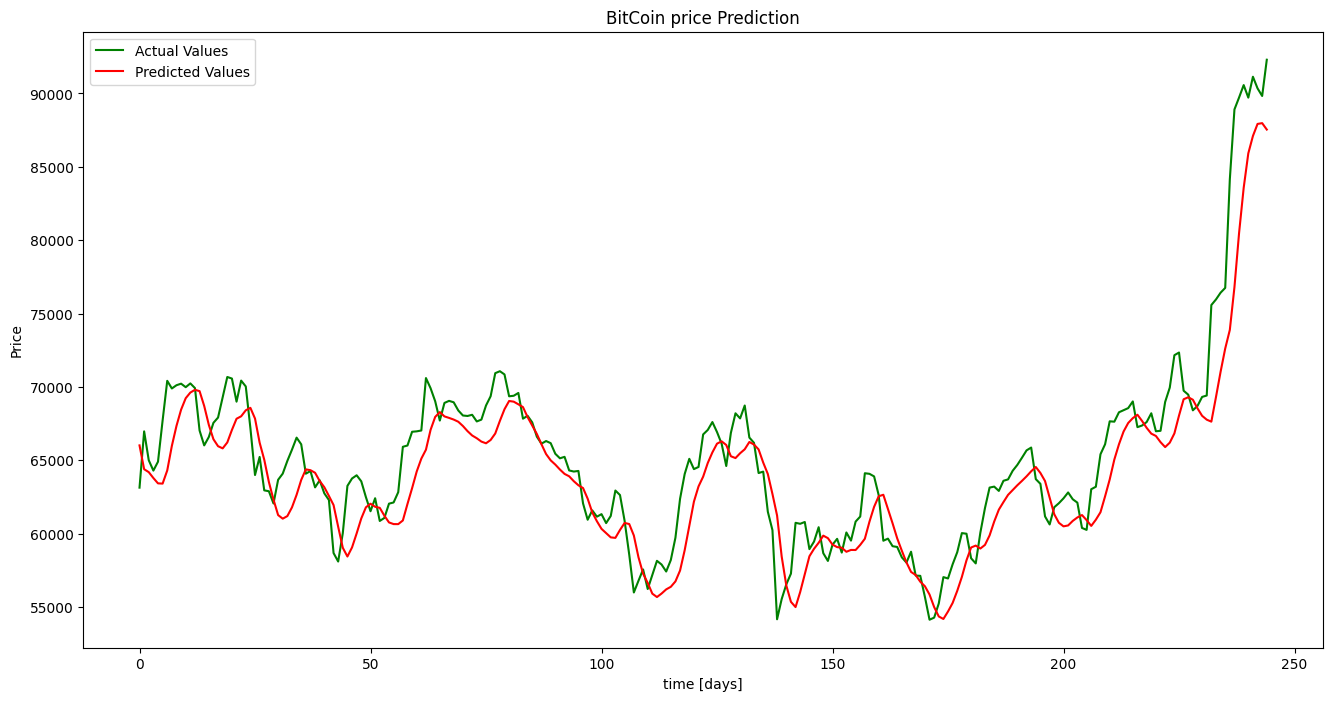

In [12]:
predict_prices =lstm_model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='green')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='red')
 
plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

##GRU

Besides LSTM, we will try to evaluate the performace by implementing GRU model on our network. We will try to keep the network simple just as LSTM network and try to analyze the performance.

In [14]:
model_name = 'stock_price_GRU'

gru_model = Sequential()
gru_model.add(GRU(units=100,
              return_sequences=True, 
              input_shape=(WINDOW_SIZE,x_train.shape[-1])))
gru_model.add(Dropout(DROPOUT))
gru_model.add(GRU(units=100))
gru_model.add(Dropout(DROPOUT))
gru_model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

print(gru_model.summary())



# Set activation function
#model.add(Activation('relu')) 
# compile and fit the model
gru_model.compile(loss='mean_squared_error', optimizer='adam')

history =gru_model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


d:\DL\virtual env tenserflow\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 49, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 49, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,601 (357.82 KB)

 Trainable params: 91,601 (357.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0600 - val_loss: 0.0060
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0036 - val_loss: 0.0088
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0033 - val_loss: 0.0105
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms

We can then plot the graph to see the performance of our GRU model. 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


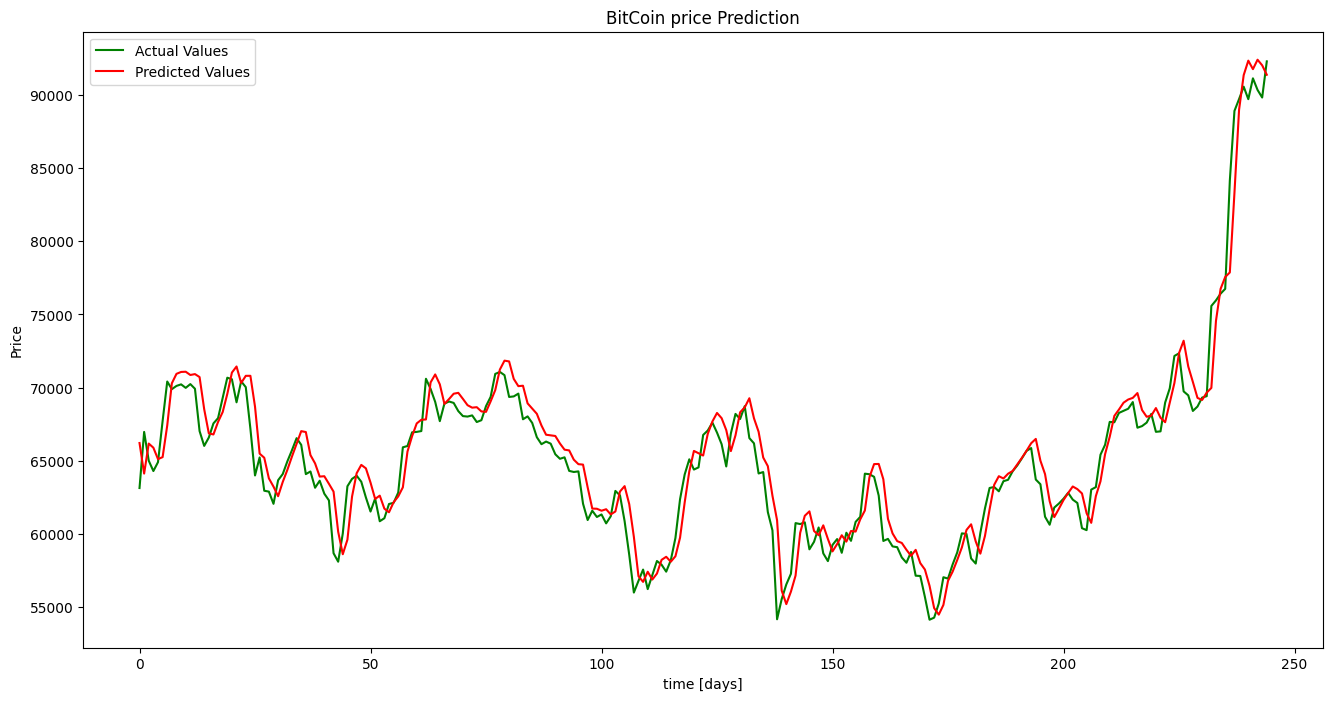

In [15]:
predict_prices = gru_model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='green')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='red')
 
plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Predict the values using the LSTM model
predicted_values_lstm = lstm_model.predict(x_test)



# Calculate Mean Squared Error (MSE) for LSTM
lstm_mse = mean_squared_error(y_test, predicted_values_lstm)
print(f"LSTM - Mean Squared Error: {lstm_mse}")

# Calculate Root Mean Squared Error (RMSE) for LSTM
lstm_rmse = np.sqrt(lstm_mse)
print(f"LSTM - Root Mean Squared Error: {lstm_rmse}")

# Calculate Mean Absolute Error (MAE) for LSTM
lstm_mae = mean_absolute_error(y_test, predicted_values_lstm)
print(f"LSTM - Mean Absolute Error: {lstm_mae}")

# Calculate R² Score for LSTM
lstm_r2 = r2_score(y_test, predicted_values_lstm)
print(f"LSTM - R² Score: {lstm_r2}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM - Mean Squared Error: 0.0012539837817991642
LSTM - Root Mean Squared Error: 0.03541163342461294
LSTM - Mean Absolute Error: 0.026552120716282254
LSTM - R² Score: 0.8256207802517084


In [17]:
# Predict the values using the GRU model
predicted_values_gru = gru_model.predict(x_test)



# Calculate Mean Squared Error (MSE) for GRU
gru_mse = mean_squared_error(y_test, predicted_values_gru)
print(f"GRU - Mean Squared Error: {gru_mse}")

# Calculate Root Mean Squared Error (RMSE) for GRU
gru_rmse = np.sqrt(gru_mse)
print(f"GRU - Root Mean Squared Error: {gru_rmse}")

# Calculate Mean Absolute Error (MAE) for GRU
gru_mae = mean_absolute_error(y_test, predicted_values_gru)
print(f"GRU - Mean Absolute Error: {gru_mae}")

# Calculate R² Score for GRU
gru_r2 = r2_score(y_test, predicted_values_gru)
print(f"GRU - R² Score: {gru_r2}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
GRU - Mean Squared Error: 0.0004960579506548124
GRU - Root Mean Squared Error: 0.022272358443928036
GRU - Mean Absolute Error: 0.01660040369818186
GRU - R² Score: 0.9310180883990278


In [18]:
# Comparing the performance of GRU and LSTM
print("------ GRU Model Evaluation ------")
print(f"MSE: {gru_mse}, RMSE: {gru_rmse}, MAE: {gru_mae}, R²: {gru_r2}")

print("\n------ LSTM Model Evaluation ------")
print(f"MSE: {lstm_mse}, RMSE: {lstm_rmse}, MAE: {lstm_mae}, R²: {lstm_r2}")


------ GRU Model Evaluation ------
MSE: 0.0004960579506548124, RMSE: 0.022272358443928036, MAE: 0.01660040369818186, R²: 0.9310180883990278

------ LSTM Model Evaluation ------
MSE: 0.0012539837817991642, RMSE: 0.03541163342461294, MAE: 0.026552120716282254, R²: 0.8256207802517084


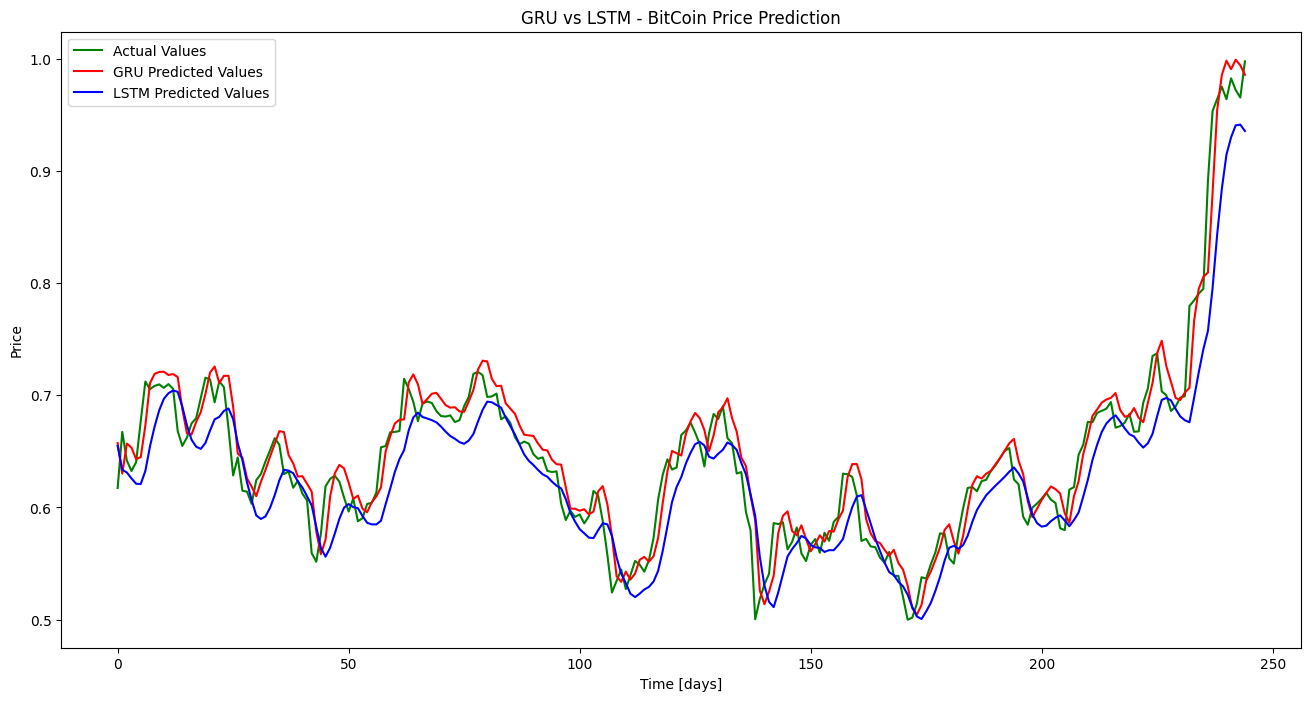

In [19]:
# Comparing the predictions visually
plt.figure(figsize=(16,8))

# Plot Actual vs Predicted for GRU
plt.plot((y_test), label="Actual Values", color='green')
plt.plot(predicted_values_gru, label="GRU Predicted Values", color='red')

# Plot Actual vs Predicted for LSTM
plt.plot(predicted_values_lstm, label="LSTM Predicted Values", color='blue')

plt.title('GRU vs LSTM - BitCoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()


Bidirectional LSTM outperformed the GRU model for the Cryptocurrency Market Analysis.